# Sprawozdanie z laboratorium Podstaw sztuczenj inteligencji z ćwiczenia C2

## Skład zespołu:
 - Damian Cienkowski
 - Karol Aleksander Cichor
 - Maciej Staszczyk

## Cel ćwiczenia
Celem ćwiczenia było zbadanie wpływu metod skalowania funkcji przystosowania na wynik selekcji w algorytmach genetycznych. Wybraliśmy dwie funkcje testowe: **Sphere** i **Matyas**, dwie metody skalowania: **liniowe** i **potęgowe**, oraz selekcje **deterministyczną**.

## Funkcje testowe

In [163]:
import numpy as np

def Sphere(X):
    return np.sum(X*X, axis = 1).reshape(-1,1)

def Matyas(X):
    return (0.26 * (Sphere(X)) - (0.48 * X[:, 0] * X[:, 1]).reshape(-1,1)).reshape(-1,1)

Obie funkcje przed selekcją musimy zamienić na funkcję przystosowania.

## Tworzenie populacji


Zakładamy rozkład jednorodny rozwiązań losowanych i generujemy w oparciu o zakres zmienności argumentów wejścia wykorzystując populację 100 osobników o dwóch wymiarach (`d = 2`).

In [164]:
N = 100
X_sphere = np.random.uniform(low = -5.12, high = 5.12, size = (100,2))
X_matyas = np.random.uniform(low = -10, high = 10, size = (100,2))

## Funkcja przystosowania

Zgodnie z instrukcją, funkcję celu przekształcamy do postaci: `(Funkcja przystosowania = 1 / (Funkcja celu + epsilon)` gdzie epsilon jest stałą numeryczną odpowiedzialną za uniknięcie dzielenia przez zero.

In [165]:
def eval(X, function = "sphere",epsilon = 0.001):
    if(function == "sphere"):
        return 1 / (Sphere(X) + epsilon).reshape(-1,1)
    elif(function == "matyas"):
        return 1 / (Matyas(X) + epsilon).reshape(-1,1)
    
Y_sphere = eval(X_sphere)
Y_matyas = eval(X_matyas, "matyas")

Ta transformacja pozwala przekształcić problem minimalizacji w klasyczny problem maksymalizacji.

## Skalowanie funkcji przystosowania

In [166]:
def linear_scaling(X, C = 4, function = "sphere"):
    eval_X = eval(X,function)
    eval_min = np.min(eval_X)
    eval_max = np.max(eval_X)
    F_mean = np.sum(eval_X) / eval_X.shape[0]
    treshold = ( C * F_mean - eval_max ) / ( C - 1.0 )

    if( eval_min > treshold ):
        a = ( ((C-1.0) * F_mean ) / ( eval_max - F_mean) )
        b = F_mean * (eval_max - C * F_mean) / (eval_max - F_mean)
    else:
        a = F_mean / (F_mean - eval_min)
        b = -eval_min * (F_mean) / (F_mean - eval_min)
    
    return a * eval_X + b

Skalowanie liniowe umożliwia kontrolę selektywności przez parametr C (wspólczynnik zwielokrotnienia). Dla zalecanych w instrukcji wartości tego parametru (`1.2 - 2.0`) efekty były niemalże niewidoczne, dlatego zdecydowaliśmy się na testowanie z większą wartościątego współczynnika, co przyniosło znacznie lepszy efekt.


In [167]:
def exponential_scaling(X, t, T, function = "sphere", p1 = 0.05, p2 = 0.1, a = 0.1, s_star = 0.1):
    eval_X = eval(X, function)
    s0 = np.max(eval_X) - np.min(eval_X) # według wskazań prowadzącego
    k1 = (s_star/s0) ** p1
    k2 = np.tan(t/(T+1) * np.pi / 2)
    k = k1 * k2 ** (p2*((s0/s_star)**a))
    return np.power(eval_X,k)

W przypadku skalowania potęgowego, wartość funkcji przystosowania pierwotnego `i`-tego osobnika, należy podnieść do ustalonej potęgi `k`. Do jego wyznaczenia posłużyliśmy się wzorem z instrukcji do ćwiczenia.

## Skalowanie populacji

Następnie wykonujemy skalowanie obu przystosowań populacji (Sphere i Matyas) przy użyciu obu metod skalowania. Za całkowitą liczbe pokoleń przyjmujemy `T = 100`.

In [168]:
Y_sphere_linear = linear_scaling(X_sphere, function = "sphere")
Y_sphere_exponential = exponential_scaling(X_sphere, 1, 100, function = "sphere")

Y_matyas_linear = linear_scaling(X_matyas, function = "matyas")
Y_matyas_exponential = exponential_scaling(X_matyas, 1, 100, function = "matyas")

W efekcie uzyskaliśmy łącznie 6 wariantów funkcji przystosowania — po trzy dla każdej funkcji celu (Sphere i Matyas), obejmujące: wersję bez skalowania, wersję po skalowaniu liniowym oraz wersję po skalowaniu potęgowym.

In [169]:
print("Sphere bez skalowania:\n", Y_sphere[:10])
print("\nSphere + linear:\n", linear_scaling(X_sphere)[:10])
print("\nSphere + exp:\n", exponential_scaling(X_sphere, t=1, T=100)[:10])

Sphere bez skalowania:
 [[0.02934029]
 [0.88942894]
 [0.03903728]
 [0.04595725]
 [0.03200688]
 [0.03719568]
 [0.06876006]
 [0.03287841]
 [0.05399781]
 [0.08197782]]

Sphere + linear:
 [[0.1176877 ]
 [0.26116804]
 [0.11930536]
 [0.12045975]
 [0.11813254]
 [0.11899814]
 [0.12426372]
 [0.11827793]
 [0.12180108]
 [0.12646871]]

Sphere + exp:
 [[0.09797842]
 [0.92576316]
 [0.11824145]
 [0.13165168]
 [0.10375292]
 [0.11453914]
 [0.17163957]
 [0.10560416]
 [0.14639359]
 [0.1927016 ]]


In [170]:
print("\nMatyas bez skalowania:\n", Y_matyas[:10])
print("\nMatyas + linear:\n", linear_scaling(X_matyas, function='matyas')[:10])
print("\nMatyas + exp:\n", exponential_scaling(X_matyas, t=1, T=100, function='matyas')[:10])


Matyas bez skalowania:
 [[1.73070261]
 [0.33367232]
 [0.08240975]
 [0.03859386]
 [0.01916744]
 [6.10645726]
 [0.02199609]
 [0.03042117]
 [0.03329591]
 [0.2577318 ]]

Matyas + linear:
 [[0.77714834]
 [0.43214611]
 [0.37009581]
 [0.3592753 ]
 [0.35447787]
 [1.85775848]
 [0.35517642]
 [0.35725702]
 [0.35796695]
 [0.4133923 ]]

Matyas + exp:
 [[1.40176884]
 [0.50874781]
 [0.21505775]
 [0.13480389]
 [0.08761011]
 [3.04663099]
 [0.09535914]
 [0.11643226]
 [0.12308879]
 [0.43395943]]


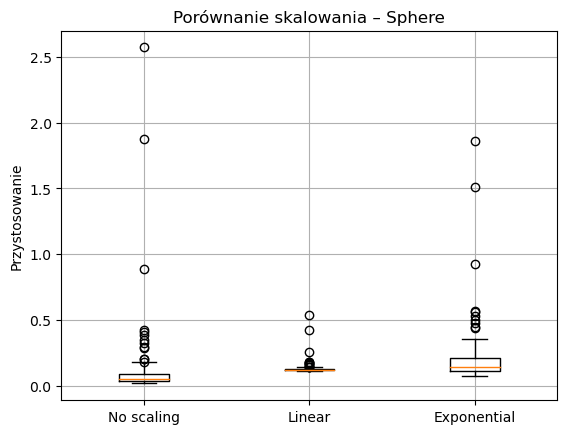

In [171]:
import matplotlib.pyplot as plt

sphere_no = Y_sphere.flatten()
sphere_lin = linear_scaling(X_sphere).flatten()
sphere_exp = exponential_scaling(X_sphere, t=1, T=100).flatten()

plt.boxplot([sphere_no, sphere_lin, sphere_exp], labels=['No scaling', 'Linear', 'Exponential'])
plt.title('Porównanie skalowania – Sphere')
plt.ylabel('Przystosowanie')
plt.grid(True)
plt.show()

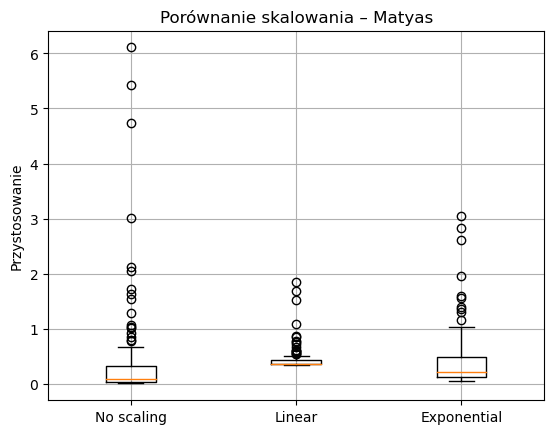

In [172]:
matyas_no = Y_matyas.flatten()
matyas_lin = linear_scaling(X_matyas, function='matyas').flatten()
matyas_exp = exponential_scaling(X_matyas, t=1, T=100, function='matyas').flatten()

plt.boxplot([matyas_no, matyas_lin, matyas_exp], labels=['No scaling', 'Linear', 'Exponential'])
plt.title('Porównanie skalowania – Matyas')
plt.ylabel('Przystosowanie')
plt.grid(True)
plt.show()

In [173]:
def show_stats(name, data):
    print(f"{name} — Mean: {np.mean(data):.4f}, Std: {np.std(data):.4f}, Min: {np.min(data):.4f}, Max: {np.max(data):.4f}")

print("Statystyki dla funkcji Sphere:")
show_stats("No scaling", sphere_no)
show_stats("Linear", sphere_lin)
show_stats("Exponential", sphere_exp)

print("\nStatystyki dla funkcji Matyas:")
show_stats("No scaling", matyas_no)
show_stats("Linear", matyas_lin)
show_stats("Exponential", matyas_exp)

Statystyki dla funkcji Sphere:
No scaling — Mean: 0.1354, Std: 0.3242, Min: 0.0196, Max: 2.5699
Linear — Mean: 0.1354, Std: 0.0541, Min: 0.1161, Max: 0.5415
Exponential — Mean: 0.2188, Std: 0.2492, Min: 0.0751, Max: 1.8614

Statystyki dla funkcji Matyas:
No scaling — Mean: 0.4644, Std: 1.0205, Min: 0.0112, Max: 6.1065
Linear — Mean: 0.4644, Std: 0.2520, Min: 0.3525, Max: 1.8578
Exponential — Mean: 0.4578, Std: 0.5702, Min: 0.0631, Max: 3.0466


## Wnioski
### Wpływ metody skalowania funkcji przystosowania:

   - Zarówno dla funkcji Sphere, jak i Matyas, skalowanie funkcji przystosowania istotnie wpływa na wartości przystosowania osobników.

   - Skalowanie liniowe prowadzi do bardziej równomiernego rozkładu przystosowania, zmniejszając odchylenie standardowe w porównaniu do braku skalowania.

   - Skalowanie wykładnicze skutkuje większym kontrastem między najlepszymi a najsłabszymi osobnikami, co potencjalnie może prowadzić do szybszej konwergencji, ale zwiększa ryzyko utraty różnorodności populacji.

## Selekcja deterministyczna

Polega na przypisaniu każdemu osobnikowi liczby kopii w nowej populacji proporcjonalnie do jego przystosowania względem całej grupy. Jest metodą bez losowości – najlepiej przystosowani osobnicy są zawsze wybierani, co zwiększa presję selekcyjną, ale może prowadzić do szybszej utraty różnorodności.

In [174]:
def deterministic_choice(X, eval_X):
    N = eval_X.shape[0]
    F_sum = np.sum(eval_X)

    P = (eval_X / F_sum)
    E = P * N
    E_floor = np.floor(E)
    R = E - E_floor
    
    E_floor_sum = int(np.sum(E_floor))
    print(E_floor_sum)
    free_slots = N - E_floor_sum

    X_new_list = []
    c = 0
    for i in range(N):
        for j in range(int(E_floor[i])):
            X_new_list.append(X[i])

    dt = np.concatenate((X,R), axis = 1)
    sorted_dt = dt[dt[:, 2].argsort()[::-1]]

    for i in range(free_slots):
        X_new_list.append(sorted_dt[i, :X.shape[1]])
        
    X_new = np.array(X_new_list)
    return X_new

## Selekcja populacji

In [175]:
X_sphere_new = deterministic_choice(X_sphere, Y_sphere)
X_matyas_new = deterministic_choice(X_matyas, Y_matyas)

X_sphere_linear_new = deterministic_choice(X_sphere, Y_sphere_linear)
X_matyas_linear_new = deterministic_choice(X_matyas, Y_matyas_linear)

X_sphere_exponential_new = deterministic_choice(X_sphere, Y_sphere_exponential)
X_matyas_exponential_new = deterministic_choice(X_matyas, Y_matyas_exponential)

62
72
23
27
40
50


Na podstawie przygotowanych sześciu wariantów funkcji przystosowania wykonaliśmy selekcję deterministyczną, w wyniku której otrzymaliśmy kolejne 6 nowych populacji — po jednej dla każdego wariantu (oryginalnego, liniowego i potęgowego) osobno dla funkcji Sphere i Matyas.

In [176]:
Y_sphere_sel = eval(X_sphere_new)
Y_matyas_sel = eval(X_matyas_new, function="matyas")

Y_sphere_sel_lin = eval(X_sphere_linear_new)
Y_sphere_sel_exp = eval(X_sphere_exponential_new)

Y_matyas_sel_lin = eval(X_matyas_linear_new, function="matyas")
Y_matyas_sel_exp = eval(X_matyas_exponential_new, function="matyas")

In [177]:
print("Sphere (po selekcji, bez skalowania):\n", Y_sphere_sel[:10])
print("\nSphere (po selekcji, linear):\n", Y_sphere_sel_lin[:10])
print("\nSphere (po selekcji, exp):\n", Y_sphere_sel_exp[:10])

Sphere (po selekcji, bez skalowania):
 [[0.88942894]
 [0.88942894]
 [0.88942894]
 [0.88942894]
 [0.88942894]
 [0.88942894]
 [0.42817305]
 [0.42817305]
 [0.42817305]
 [2.56991233]]

Sphere (po selekcji, linear):
 [[0.88942894]
 [0.42817305]
 [2.56991233]
 [2.56991233]
 [2.56991233]
 [0.17919597]
 [0.16180756]
 [0.16731923]
 [0.2945708 ]
 [0.32415221]]

Sphere (po selekcji, exp):
 [[0.88942894]
 [0.88942894]
 [0.88942894]
 [0.42817305]
 [0.42817305]
 [2.56991233]
 [2.56991233]
 [2.56991233]
 [2.56991233]
 [2.56991233]]


In [178]:
print("\nMatyas (po selekcji, bez skalowania):\n", Y_matyas_sel[:10])
print("\nMatyas (po selekcji, linear):\n", Y_matyas_sel_lin[:10])
print("\nMatyas (po selekcji, exp):\n", Y_matyas_sel_exp[:10])


Matyas (po selekcji, bez skalowania):
 [[1.73070261]
 [1.73070261]
 [1.73070261]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [6.10645726]]

Matyas (po selekcji, linear):
 [[1.73070261]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [2.13253663]
 [0.79397705]
 [2.05879489]
 [3.0063177 ]
 [3.0063177 ]
 [0.60046112]]

Matyas (po selekcji, exp):
 [[1.73070261]
 [1.73070261]
 [0.33367232]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [6.10645726]
 [0.2577318 ]
 [0.26930955]
 [2.13253663]]


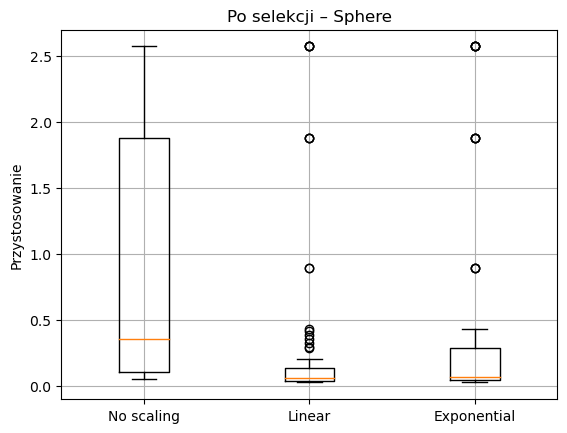

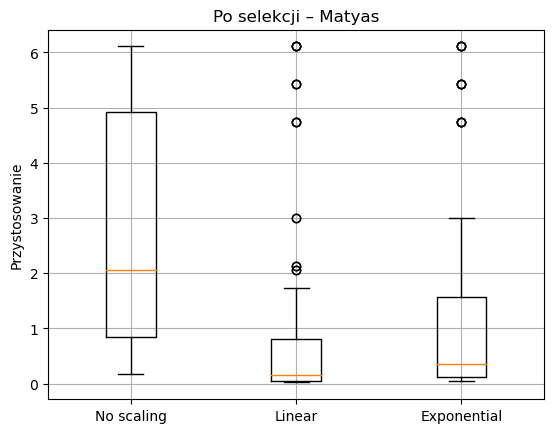

In [179]:
plt.boxplot([
    Y_sphere_sel.flatten(), 
    Y_sphere_sel_lin.flatten(), 
    Y_sphere_sel_exp.flatten()
], labels=['No scaling', 'Linear', 'Exponential'])
plt.title('Po selekcji – Sphere')
plt.ylabel('Przystosowanie')
plt.grid(True)
plt.show()

plt.boxplot([
    Y_matyas_sel.flatten(), 
    Y_matyas_sel_lin.flatten(), 
    Y_matyas_sel_exp.flatten()
], labels=['No scaling', 'Linear', 'Exponential'])
plt.title('Po selekcji – Matyas')
plt.ylabel('Przystosowanie')
plt.grid(True)
plt.show()


In [180]:
print("Statystyki po selekcji — Sphere:")
show_stats("No scaling", Y_sphere_sel)
show_stats("Linear", Y_sphere_sel_lin)
show_stats("Exponential", Y_sphere_sel_exp)

print("\nStatystyki po selekcji — Matyas:")
show_stats("No scaling", Y_matyas_sel)
show_stats("Linear", Y_matyas_sel_lin)
show_stats("Exponential", Y_matyas_sel_exp)

Statystyki po selekcji — Sphere:
No scaling — Mean: 0.9244, Std: 0.9891, Min: 0.0540, Max: 2.5699
Linear — Mean: 0.2575, Std: 0.5774, Min: 0.0263, Max: 2.5699
Exponential — Mean: 0.3328, Std: 0.6379, Min: 0.0329, Max: 2.5699

Statystyki po selekcji — Matyas:
No scaling — Mean: 2.7597, Std: 2.1427, Min: 0.1698, Max: 6.1065
Linear — Mean: 0.9216, Std: 1.6566, Min: 0.0209, Max: 6.1065
Exponential — Mean: 1.2298, Std: 1.7161, Min: 0.0386, Max: 6.1065


In [181]:
def compare_before_after(name, before, after):
    print(f"\n{name}")
    print(f"  Przed selekcją:   mean = {np.mean(before):.4f}, std = {np.std(before):.4f}")
    print(f"  Po selekcji:      mean = {np.mean(after):.4f}, std = {np.std(after):.4f}")
    print(f"  Różnica średnich: {(np.mean(after) - np.mean(before)):.4f}")
    print(f"  Różnica std:      {(np.std(after) - np.std(before)):.4f}")

In [182]:
compare_before_after("Sphere – No scaling", sphere_no, Y_sphere_sel.flatten())
compare_before_after("Sphere – Linear", sphere_lin, Y_sphere_sel_lin.flatten())
compare_before_after("Sphere – Exponential", sphere_exp, Y_sphere_sel_exp.flatten())


Sphere – No scaling
  Przed selekcją:   mean = 0.1354, std = 0.3242
  Po selekcji:      mean = 0.9244, std = 0.9891
  Różnica średnich: 0.7890
  Różnica std:      0.6649

Sphere – Linear
  Przed selekcją:   mean = 0.1354, std = 0.0541
  Po selekcji:      mean = 0.2575, std = 0.5774
  Różnica średnich: 0.1221
  Różnica std:      0.5233

Sphere – Exponential
  Przed selekcją:   mean = 0.2188, std = 0.2492
  Po selekcji:      mean = 0.3328, std = 0.6379
  Różnica średnich: 0.1139
  Różnica std:      0.3888


In [183]:
compare_before_after("Matyas – No scaling", matyas_no, Y_matyas_sel.flatten())
compare_before_after("Matyas – Linear", matyas_lin, Y_matyas_sel_lin.flatten())
compare_before_after("Matyas – Exponential", matyas_exp, Y_matyas_sel_exp.flatten())


Matyas – No scaling
  Przed selekcją:   mean = 0.4644, std = 1.0205
  Po selekcji:      mean = 2.7597, std = 2.1427
  Różnica średnich: 2.2953
  Różnica std:      1.1222

Matyas – Linear
  Przed selekcją:   mean = 0.4644, std = 0.2520
  Po selekcji:      mean = 0.9216, std = 1.6566
  Różnica średnich: 0.4572
  Różnica std:      1.4046

Matyas – Exponential
  Przed selekcją:   mean = 0.4578, std = 0.5702
  Po selekcji:      mean = 1.2298, std = 1.7161
  Różnica średnich: 0.7721
  Różnica std:      1.1459


## Wnioski
### Wpływ selekcji deterministycznej:

   - Selekcja deterministyczna zawsze poprawia średnie przystosowanie populacji w porównaniu do populacji początkowej.

   - Największe zyski obserwowano po skalowaniu wykładniczym, ale również zaobserwowano większy rozrzut wyników, co oznacza, że selekcja mogła preferować ekstremalne wartości.

   - Skalowanie liniowe w połączeniu z selekcją deterministyczną daje bardziej stabilne i przewidywalne wyniki.

   - Porównanie funkcji Sphere i Matyas:

   - Funkcja Sphere wydaje się bardziej wrażliwa na wybór metody skalowania – różnice między metodami były wyraźniejsze niż w przypadku funkcji Matyas.

   - Dla funkcji Matyas wszystkie metody dały bardziej zbliżone wyniki, co sugeruje, że problem ten jest bardziej "płaski" i mniej podatny na agresywną selekcję.

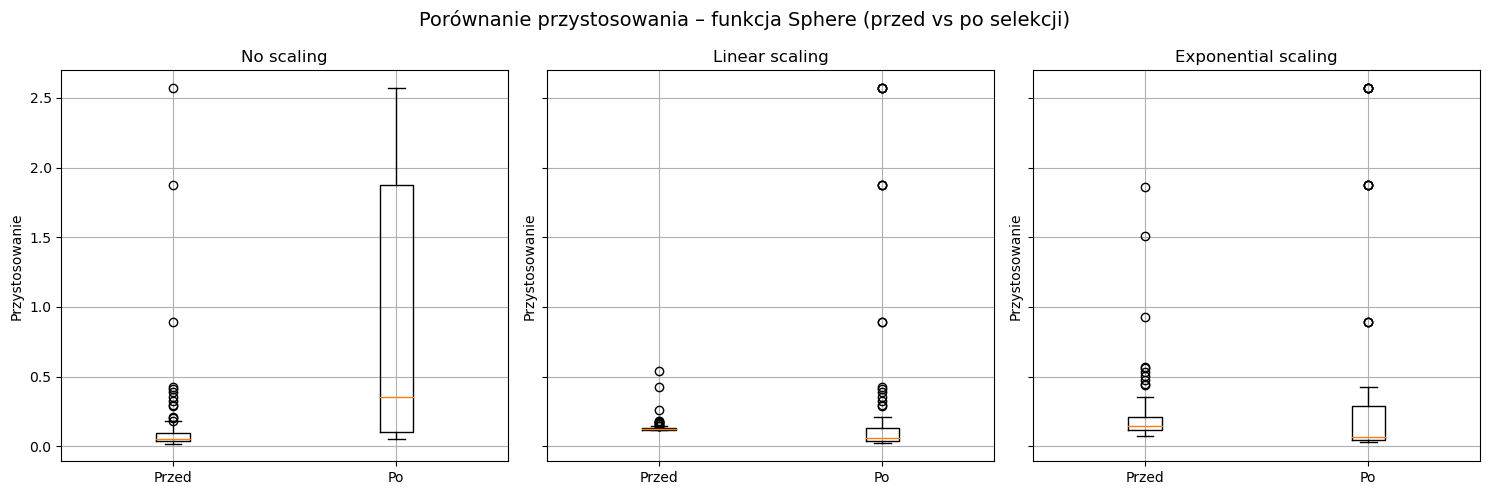

In [190]:
sphere_no = Y_sphere.flatten()
sphere_lin = linear_scaling(X_sphere).flatten()
sphere_exp = exponential_scaling(X_sphere, t=1, T=100).flatten()

sphere_sel_no = Y_sphere_sel.flatten()
sphere_sel_lin = Y_sphere_sel_lin.flatten()
sphere_sel_exp = Y_sphere_sel_exp.flatten()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
scenarios = ['No scaling', 'Linear scaling', 'Exponential scaling']
data_pairs = [
    (sphere_no, sphere_sel_no),
    (sphere_lin, sphere_sel_lin),
    (sphere_exp, sphere_sel_exp)
]

for i, (before, after) in enumerate(data_pairs):
    axs[i].boxplot([before, after], labels=['Przed', 'Po'])
    axs[i].set_title(scenarios[i])
    axs[i].set_ylabel('Przystosowanie')
    axs[i].grid(True)

fig.suptitle('Porównanie przystosowania – funkcja Sphere (przed vs po selekcji)', fontsize=14)
plt.tight_layout()
plt.show()

## Wnioski
- **Selekcja deterministyczna** wyraźnie poprawia średnie przystosowanie populacji we wszystkich trzech przypadkach skalowania.
- W przypadku **braku skalowania**, rozrzut przystosowania po selekcji jest największy – co może wskazywać na wybieranie skrajnych wartości bez kontroli.
- **Skalowanie liniowe** i **wykładnicze** ograniczają ten rozrzut i powodują bardziej „ściśnięty” rozkład osobników po selekcji – co może wpływać korzystnie na zbieżność algorytmu.
- **Skalowanie wykładnicze** prowadzi do najbardziej widocznej poprawy mediany przystosowania, co czyni je najefektywniejszym podejściem w tej funkcji.

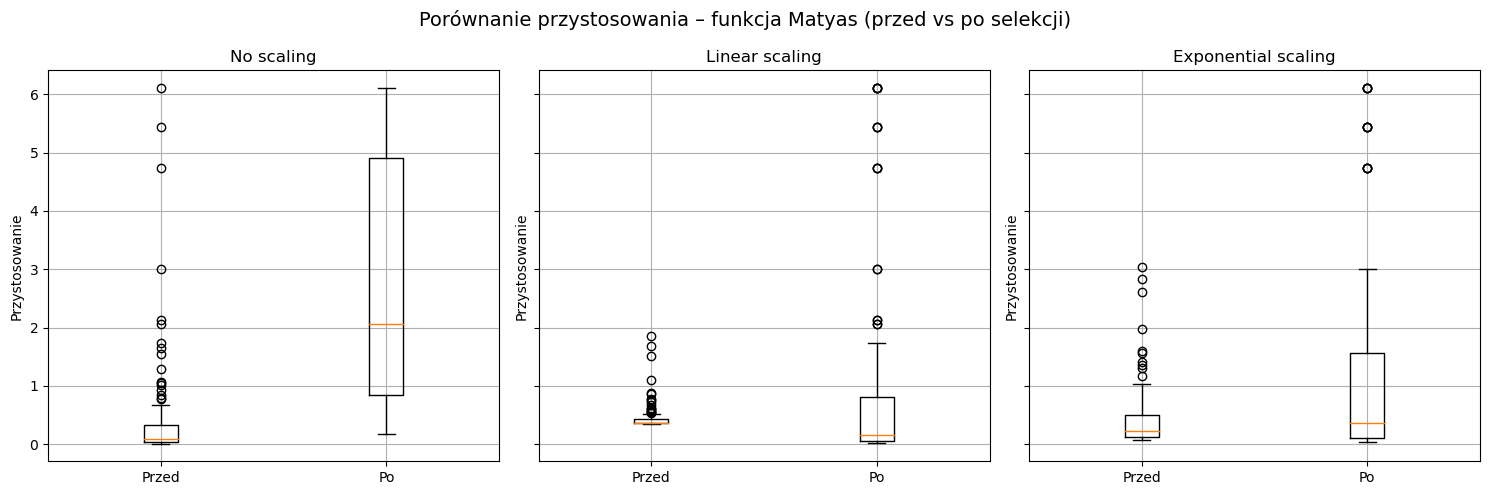

In [191]:
matyas_no = Y_matyas.flatten()
matyas_lin = linear_scaling(X_matyas, function='matyas').flatten()
matyas_exp = exponential_scaling(X_matyas, t=1, T=100, function='matyas').flatten()

matyas_sel_no = Y_matyas_sel.flatten()
matyas_sel_lin = Y_matyas_sel_lin.flatten()
matyas_sel_exp = Y_matyas_sel_exp.flatten()

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
scenarios = ['No scaling', 'Linear scaling', 'Exponential scaling']
data_pairs = [
    (matyas_no, matyas_sel_no),
    (matyas_lin, matyas_sel_lin),
    (matyas_exp, matyas_sel_exp)
]

for i, (before, after) in enumerate(data_pairs):
    axs[i].boxplot([before, after], labels=['Przed', 'Po'])
    axs[i].set_title(scenarios[i])
    axs[i].set_ylabel('Przystosowanie')
    axs[i].grid(True)

fig.suptitle('Porównanie przystosowania – funkcja Matyas (przed vs po selekcji)', fontsize=14)
plt.tight_layout()
plt.show()

## Wnioski
- Również tutaj selekcja poprawia jakość przystosowania, jednak różnice między metodami skalowania są mniej wyraźne niż w przypadku funkcji Sphere.
- **Brak skalowania** generuje bardzo szeroki rozrzut przystosowania po selekcji – wskazuje to na brak kontroli nad dominacją najlepszych osobników.
- **Skalowanie liniowe** działa stabilizująco, ograniczając rozrzut wyników przy jednoczesnym utrzymaniu poprawy przystosowania.
- **Skalowanie wykładnicze** poprawia przystosowanie, jednak rozrzut wyników pozostaje dość szeroki – może to sugerować tendencję do przeoptymalizowania wczesnych osobników.

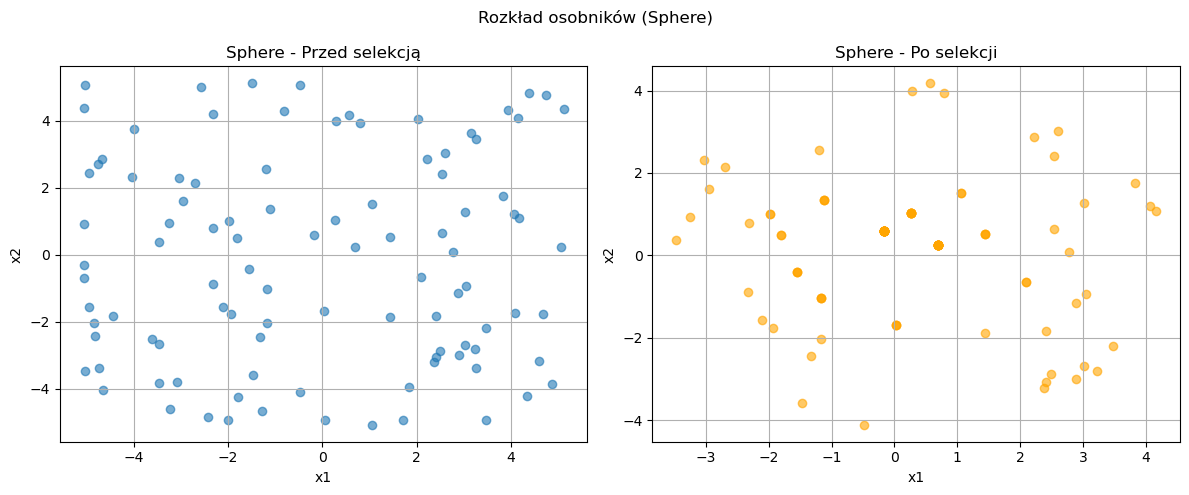

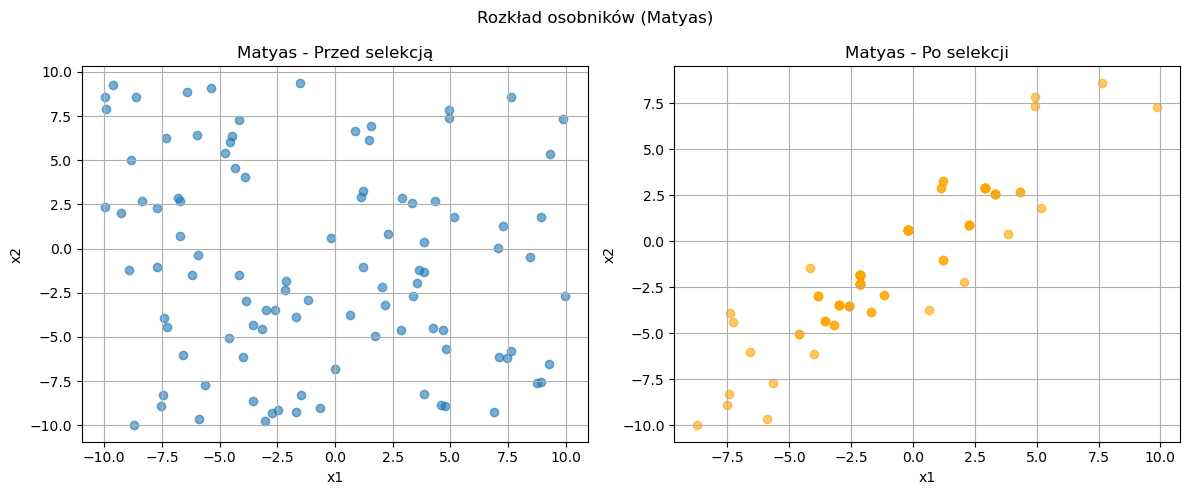

In [192]:
def plot_scatter(X_before, X_after, title_prefix):
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    
    axs[0].scatter(X_before[:, 0], X_before[:, 1], alpha=0.6)
    axs[0].set_title(f'{title_prefix} - Przed selekcją')
    axs[0].set_xlabel('x1')
    axs[0].set_ylabel('x2')
    axs[0].grid(True)

    axs[1].scatter(X_after[:, 0], X_after[:, 1], alpha=0.6, color='orange')
    axs[1].set_title(f'{title_prefix} - Po selekcji')
    axs[1].set_xlabel('x1')
    axs[1].set_ylabel('x2')
    axs[1].grid(True)

    plt.suptitle(f'Rozkład osobników ({title_prefix})')
    plt.tight_layout()
    plt.show()

plot_scatter(X_sphere, X_sphere_new, 'Sphere')
plot_scatter(X_matyas, X_matyas_new, 'Matyas')

## Wnioski

- Wykresy rozrzutu pokazały, że **selekcja deterministyczna** prowadzi do wyraźnego **skupienia osobników wokół minimum funkcji**.
- W przypadku funkcji **Sphere**, po selekcji populacja staje się bardziej skoncentrowana w obszarze o wysokim przystosowaniu, a wiele punktów pokrywa się – świadczy to o intensywnym powielaniu najlepszych osobników.
- Dla funkcji **Matyas**, efekt skupienia jest jeszcze bardziej zauważalny – duża część populacji zbiega się w jedno miejsce, co może świadczyć o szybkiej konwergencji i jednoczesnym ograniczeniu eksploracji.
- Rozrzut osobników **przed selekcją** był znacznie większy – populacja pokrywała dużą część przestrzeni przeszukiwań, co oznaczało wysoką różnorodność początkową.
- **Po selekcji**, różnorodność znacząco spada, co może być korzystne w późnych fazach optymalizacji, ale niebezpieczne na początku (grozi przedwczesną zbieżnością).

In [193]:
def analyze_diversity(X_new, Y_new):
    unique_count = len(np.unique(np.round(X_new, 6), axis=0))
    
    best_fitness = np.max(Y_new)
    best_count = np.sum(np.isclose(Y_new, best_fitness))
    
    print(f'Liczba unikalnych osobników po selekcji: {unique_count}/{len(X_new)}')
    print(f'Liczba kopii najlepszego osobnika: {best_count}')

print("Sphere:")
analyze_diversity(X_sphere_new, Y_sphere_sel)

print("\nMatyas:")
analyze_diversity(X_matyas_new, Y_matyas_sel)

Sphere:
Liczba unikalnych osobników po selekcji: 49/100
Liczba kopii najlepszego osobnika: 19

Matyas:
Liczba unikalnych osobników po selekcji: 36/100
Liczba kopii najlepszego osobnika: 13


## Wnioski

- Dla funkcji **Sphere**, po selekcji pozostało 49 unikalnych osobników na 100, a **najlepszy osobnik został skopiowany 19 razy**. Pokazuje to umiarkowane utrzymanie różnorodności, przy jednoczesnym silnym nacisku na elitę.
- W przypadku funkcji **Matyas**, tylko 36 osobników po selekcji było unikalnych, a najlepszy pojawił się 13 razy – oznacza to większe zubożenie populacji i silniejsze zdominowanie przez nieliczne rozwiązania.
- Wyniki potwierdzają, że **selekcja deterministyczna** skutecznie wzmacnia presję selekcyjną, ale może prowadzić do **znacznej utraty unikalnych rozwiązań**.
- Różnice między problemami pokazują, że **wrażliwość na skalowanie i selekcję jest zależna od krajobrazu funkcji celu** – Sphere wykazała większą stabilność, podczas gdy Matyas szybciej tracił zróżnicowanie.
- Wnioski te sugerują, że **utrzymanie balansu między eksploatacją a eksploracją** wymaga ostrożnego doboru metod skalowania oraz zastosowania mechanizmów zachowujących różnorodność (np. mutacja, losowa selekcja).

## Podsumowanie ogólne

- **Selekcja deterministyczna** skutecznie zwiększa przystosowanie populacji niezależnie od funkcji celu i metody skalowania.
- **Wybór metody skalowania** ma większe znaczenie dla funkcji Sphere niż dla Matyas – w szczególności skalowanie wykładnicze wykazało najwyższą skuteczność, ale też ryzyko nadmiernej eksploatacji najlepszych osobników.
- **Skalowanie liniowe** jest najbezpieczniejszym kompromisem między poprawą przystosowania a utrzymaniem różnorodności w populacji.
- **Różnorodność populacji po selekcji** znacząco spada, zwłaszcza w problemie Matyasa (36% unikalnych osobników), co może prowadzić do utraty eksploracyjnych właściwości algorytmu.
- **Selekcja deterministyczna** prowadzi do znacznego powielania najlepszych jednostek (do 19 kopii), co zwiększa presję selekcyjną, ale może ograniczyć zdolność do eksploracji przestrzeni rozwiązań.